# Predict-then-optimise with uncertainty

In this Notebook we consider the "predict-then-optimise" framework in which:

1. we train an ML model to predict a quantity of interest
2. we use the quantity predicted by the ML model in an optimisation problem

Our contributions are the following:

- we show that not taking into account the uncertainties of the ML predictions lead to suboptimal results in expectation
- we recommend to use an approach in which we:

    1. predict with uncertainty,
    2. include the uncertainties in the optimisation formulation, and
    3. run simulations on the results
- we introduce SAA, a method to optimise over random variables
- we introduce cVaR, a method to account for risk in optimisation problems

We will illustrate our approach on the Newvendor problem that we introduce bellow.

To learn more about the "predict-then-optimise" framework and stochastic optimisation in general, refer to [this guide](https://confluence.quantumblack.com/display/DSRD/2.+ML+and+stochastic+optimisation).

# The Newsvendor Problem

![title](images/newsvendor.jpg)

Let's assume you are a newspaper vendor. You have to order the daily newspaper the day before you can sell them. Your daily routine looks like the following:

1. You order $x$ newspapers __today__ at a price of $c$.
2. __Tomorrow__ the demand for newspapers at retail price $p$ is $d$. We note the quantity sold $s$. The demand of tomorrow is unkown, and we will see different ways to estimate it.
3. The newspapers you sell are daily, hence, you have to scrap them at a price $r$ at the end of the day. If $r$ is positive it can represent a discount rate, if it is negative it can represent a price to pay to garabage collection to get rid of them. The amount of newspapers scrapped is noted $l$.

**Optimisation problem:**

Your goal is to order the right amount of newspaper to maximise your profits.

You can formulate your daily optimization problem as follows:
$$
    \max_{x \in \mathbb{R}^{+}} p * \min(d, x) + r * \max(x-d, 0) - c * x 
$$
Note: We take $\min(d,x)$ since you can not sell more than your stock and $\max(x-d, 0)$ since if $d \geq x$ there isn't any newspaper left to sell on a discount or throw away.

Here we will optimize to minimize our loss, i.e.,
$$
    \min_{x \in \mathbb{R}^{+}} - p * \min(d, x) - r * \max(x-d, 0) + c * x 
$$

**Formulation as an LR problem:**

Although the above formulation is intuitive, it is not linear due to the min and max functions (to learn more about LP and MIP see [here](https://confluence.quantumblack.com/display/DSRD/1.1.+LP+and+MIP)). To make the problem linear, we can reformulate it as such:
$$
    \begin{align*}
    \min_{{x, s, l} \in \mathbb{R}^3} - p*s - r*l + c*x \\
    s.t. \\
    s+l=x \\ 
    s \leq d \\
    x \ge 0 \\
    s \ge 0 \\
    l \ge 0 \\
    \end{align*}
$$

The cost function is equivalent to the similar formulation; the constraints are saying in order:
- The newspapers ordered on the previous day are either sold or scrapped,
- The number of newspapers sold cannot be higher than the demand,
- The number of newspapers ordered, sold and scrapped is positive.

Let's define the parameters of the optimisation problem, and a dictionnary to store the different solutions.

In [1]:
cost    = 2 # procurement cost of each unit
retail  = 17 # selling price
recover = -3 # scrap price

# Dictionary to store results
all_solutions = dict()

# 1. "Predict-then-optimise" without uncertainty

In order to solve the above optimisation problem, you need to estimate tomorrow's demand.

Let's first imagine that you use an ML model to predict the demand as a point estimate (no uncertainty): you predict that tomorrow's demand is going to be **400**.

Intuitivelly, you would expcet to order 400 newspaper. But let's check that by solving the optimisation problem; we are using the optimisation library [CVXPY](https://www.cvxpy.org/index.html).

In [2]:
import cvxpy as cp

In [3]:
# Demand is deterministic
demand = 400

# Optimisation variables
order = cp.Variable(name="order", integer=True)
sold = cp.Variable(name="sold", integer=True)
discarded = cp.Variable(name="recover", integer=True)

# Objective and constraints
objective = cost*order - retail*sold - recover*discarded
constraints = [
    sold + discarded == order,
    sold <= demand,
    order >= 0,
    sold >= 0,
    discarded >= 0
]
p = cp.Problem(cp.Minimize(objective), constraints)

print("Profit: ", -p.solve())
print("Optimal order amount: {}".format(order.value))
all_solutions["deterministic"] = order.value

Profit:  6000.0
Optimal order amount: 400.0


As expected, the optimal number of newspapers to be ordered is 400.

# 2. "Predict-then-optimise" with uncertainty

We know that ML model predictions do not always turn out to be tue, and you might ask yourself: what if the reality turns out to be different than my prediction? Will my profit be lower than expected? By how much?

Unfortunatly, there is no way to answer those questions using a point estimate ML model. Instead, you need a probabilistic model - the good news is that there are great packages to make this easy, as NGBoost and PyMC3 (see [this  guide](https://confluence.quantumblack.com/display/DSRD/1.3.+Probabilistic+prediction) and [this brick](TODO: add link) for more details).

Once your probabilistic model is trained, you predict that tomorrow's demand should be **400** with a std of 100 (formally, tomorrow's demand is random variable that follows a normal distribution of mean 400, and std 100).

**Note:** the mean of your prediction (400) is the same as the point estimate, so intuitively the result of the optimisation should be the same as before, correct? Let's check that bellow.

In [4]:
# Demand parameters
# Demand will be drawn from a normal distribution
mu = 400
sigma = 100

## 2.1. SAA: optimising a random variable

The optimisation problem is slighlty different than before as the demand $d$ is now a random variable. How do you optimise over a random variable?

One natural way is optimise the **expectation of the cost** (we will show other ways latter). Now how do you compute the expectation the cost? Two solutions:
- either you derive its formula on pen & paper (feasible if the expression isn't too complex and if you remember enough from your maths class)
- or you approximate it using Sample Average Approximation (SAA)

I personaly forgot my maths, so we will use SAA.

You can see SAA as the Monte-Carlo simulation of optimisation. Let's say that you have a random variable $Z$ from which you can draw samples $z_1$, $z_2$, ..., $z_k$. Your decision variable is $w$ and your cost function is $c(w, z)$. Then
$$
    max_w E(c(w, Z)) \approx max_w \dfrac{1}{k} (c(w, z_1) + c(w, z_2) + ... + c(w, z_k))
$$
We are basically finding the vector w that works best on average among all the historical observations. By the law of large numbers, as k grow, the result of the estimation converges to the real value.

For more details on SAA refer to [this guide](https://confluence.quantumblack.com/pages/resumedraft.action?draftId=202247262&draftShareId=96a776d6-55db-408e-8928-62f1dc832b97&).

We apply SAA  to the newsvendor problem.

In [5]:
import numpy as np

In [6]:
nb_samples = 1000

# Sample demands
demands = np.random.normal(loc=mu, scale=sigma, size=nb_samples)
demands = [demand for demand in demands if demand > 0]
nb_samples_ = len(demands)

# Optimisation variables
order = cp.Variable(nonneg=True, name="order")
sold = cp.Variable(nb_samples_, nonneg=True, name="sold")
discarded = cp.Variable(nb_samples_, nonneg=True, name="recover")

# Ojective
objective = sum([1/nb_samples * (cost*order - retail*sold[i] - recover*discarded[i]) for i in range(nb_samples_)])

# Constraints
constraints = []
constraints_order = [sold[i] + discarded[i] == order for i in range(nb_samples)]
constraints_demand = [sold[i] <= demands[i] for i in range(nb_samples)]
constraints = constraints_order + constraints_demand

# Problem
p = cp.Problem(cp.Minimize(objective), constraints)
p.solve()

# Print solution
print("Profit: ", -p.solve())
print("Optimal order amount: {}".format(order.value))
all_solutions["expectation"] = order.value

Profit:  5422.040603943031
Optimal order amount: 475.42243382576464


Interestingly, the optimal order amount is **467** and not **400** as one could have expected.

This is due to the fact that the problem is not symetric:
- The cost of over-ordering one unit is `cost-recover = 5`
- The cost of under-ordering one unit is `retail-cost = 15`
- Hence it is preferable to slightly over-order.

More generally, when we are using a point estimate before optimising we are making the assumption that $E(c(w, X)) = c(w, E(X))$, which is false in general.

We just showed that **not taking uncertainties into account in the "predict-then-optimise" framework can lead to suboptimal decisions**.

## 2.2. Simulation on the solution

The added value of predicting with uncertainty isn't only in being able to optimise in expectation. It is also in the possibility to simulate what could happen under different scenarios.

Let's define a few helper functions for that.

In [7]:
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec
from matplotlib.ticker import PercentFormatter

random.seed(a=100)
n_bins = 150

def simulate_outcome(order, cost=cost, retail=retail, recover=recover, mu=mu, sigma=sigma, return_loss=False, nb_samples=1000):
    demand  = [max(random.normalvariate(mu, sigma),0) for i in range(nb_samples)]
    losses  = [-retail * min(order,demand[i]) + cost * order - recover * max(0,order-demand[i]) for i in range(nb_samples)]
    gains = [-loss for loss in losses]
    return (losses if return_loss else gains, demand)

# Prints the double histogram of a random variable (represented in this case as a list of values)
# First the empirical density distribution, and then the empirical accumulated probability
def doubleHist(data, xlabel=None):
    plt.figure(figsize=(14.5,6),dpi=600)
    gs  = gridspec.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.25)
    ax  = plt.subplot(gs[0])
    ax3 = plt.subplot(gs[1])
    ax.grid(True)
    ax.set_title(xlabel)
    ax.set_ylabel('Likelihood of occurrence',color='blue')
    ax2 = ax.twinx()
    ax2.set_ylabel('Cumulative probability',color='red')
    # plot the density and cumulative histogram
    n, bins, patches = ax.hist(data, n_bins, density=True, alpha=0.65, cumulative=False, label='Density', color='blue')
    n, bins, patches = ax2.hist(data, n_bins, density=True, histtype='step', cumulative=True, label='CDF', color='red')
    ax3.boxplot(data,whis=[5,95])
    # tidy up the figure
    plt.show()

The bottom graphs simulate what could happen if we were to order 467 newspaper:
- the top graph display an histogram of the demand; as per our hypothesis it is a normal distribution centered in 400 and having an std of 100
- the bottom graph shows the distribution of the losses (negative profit). The high pick at -7005 corresponds to the maximum profit when ordering 467 newspaper: for any event in which the demand is above 467 (which have 30% probability), the profit is capped at `467*(retail-cost)=7005`
-  we see that a few points have a postive cost (that is, a negative profit)

In [8]:
losses, demands = simulate_outcome(order=467, return_loss=True)

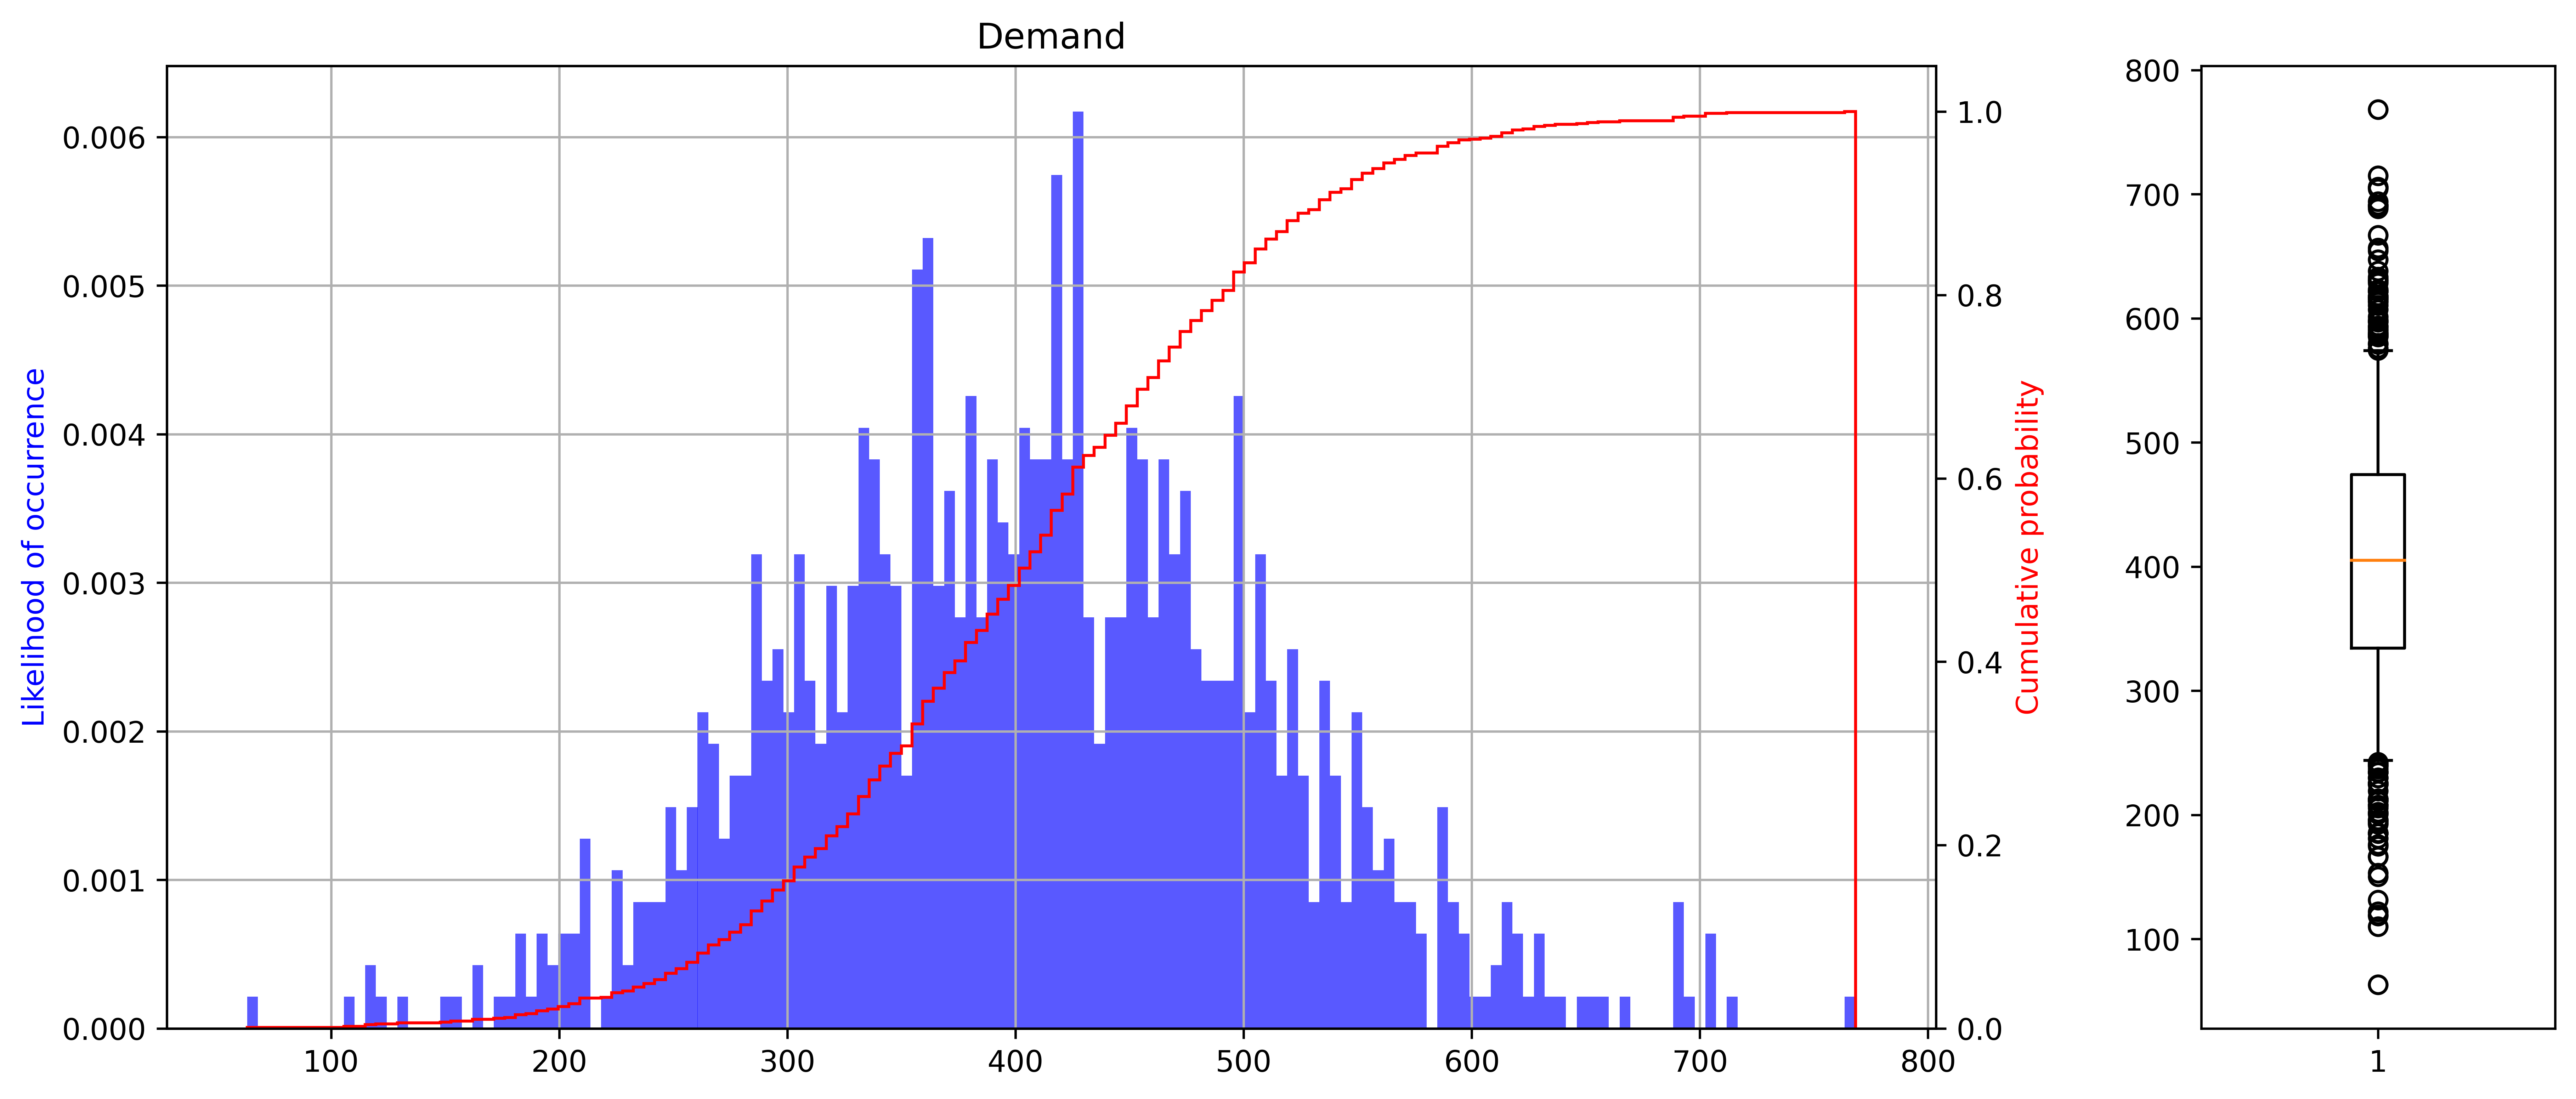

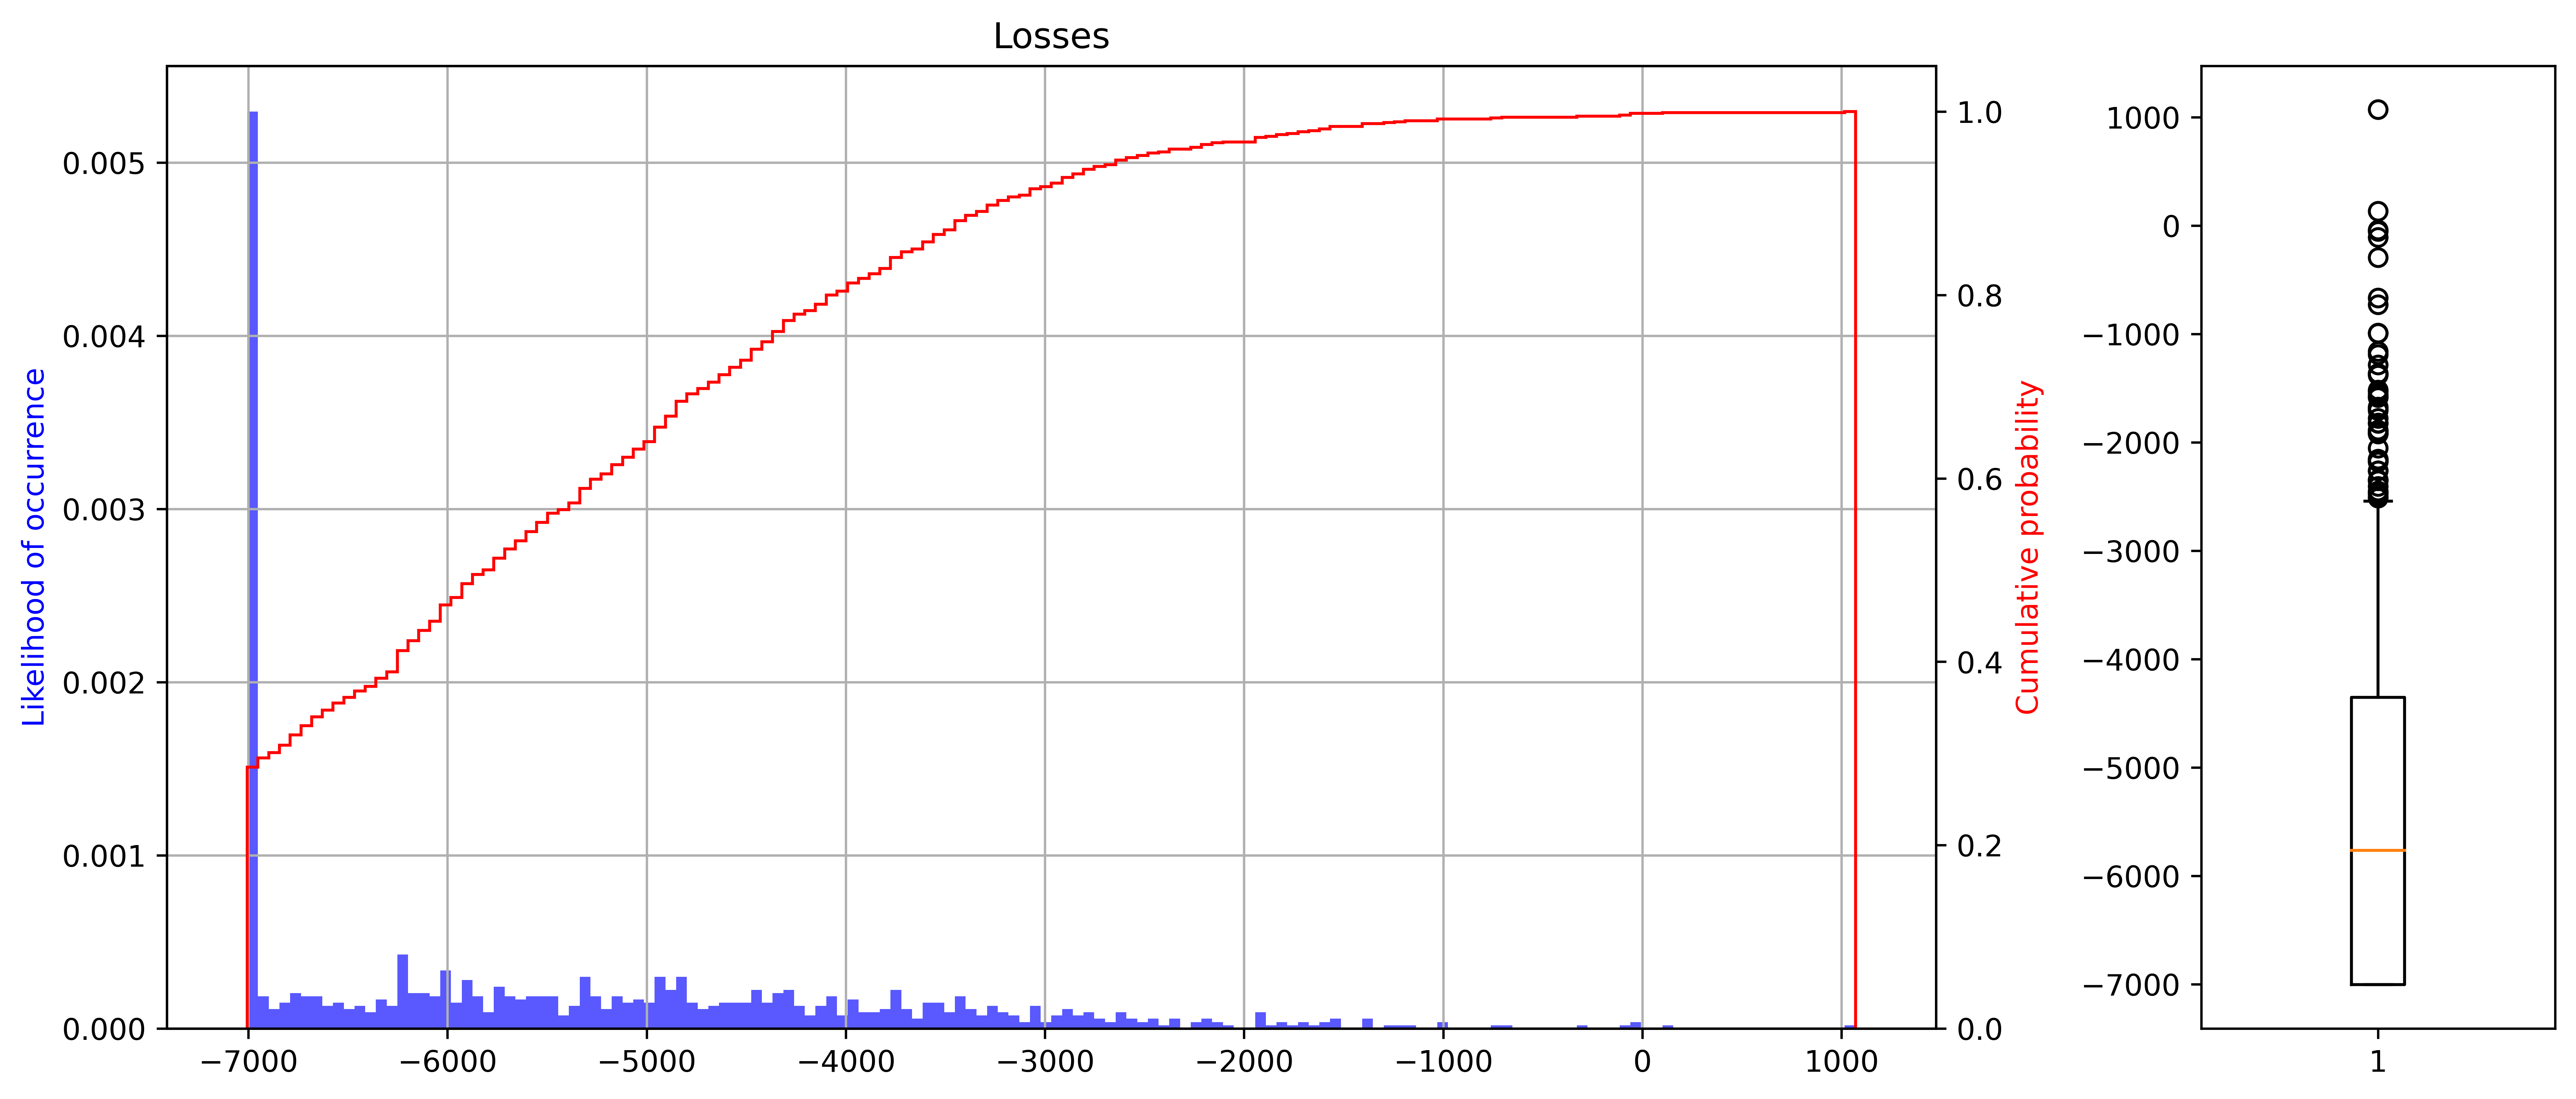

In [9]:
doubleHist(data=demands, xlabel='Demand')
doubleHist(data=losses, xlabel='Losses')

## 2.3 Simulation for any order amount

What if we are not fully happy with the solution of the expectation?

We can simulate other order amounts. In the graph bellow we simulate the profits obtained for orders going from 0 to 950. We see that:
- on the left, the orders are very small: the risk (defined as the variance of the gains) is low, but we barelly make any profit
- on the right, the orders are very large: the risk is high, in a few cases we make very large profits, but we also have high losses, which results in a rather low expected profit
- the optimum in expectation is somewhere in the middle; however as saw before, it is not at 400 (the mean is the dotted green line) but at 467.

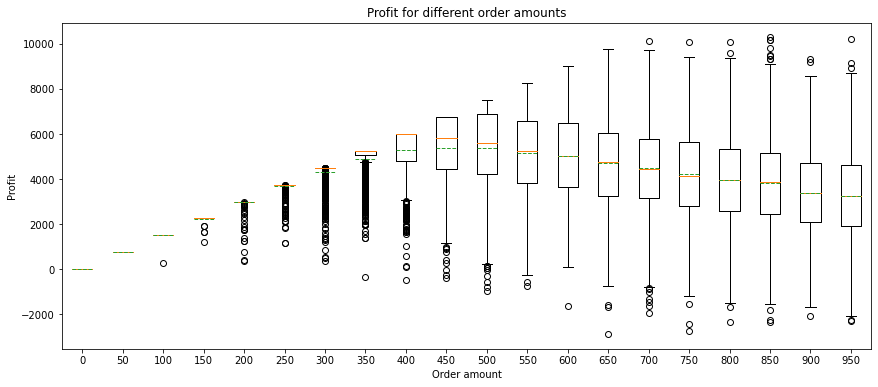

In [10]:
plt.figure(figsize=(14.5,6))
orders = list(range(0, 1000, 50))
plt.boxplot(
    [simulate_outcome(order)[0] for order in orders], showmeans=True, meanline=True,
)
plt.xticks(np.arange(1, len(orders)+1), orders)

plt.title("Profit for different order amounts")
plt.xlabel("Order amount")
plt.ylabel("Profit")
plt.show()

# 3. cVaR: risk averse objective

## 3.1. Definition

The newsvendor problem is a toy exemple in which there is only one decision variable. This allows to represent the above graph, in which we can pick our favorite solution "by eye". In particular if we are risk-averse we would go to the left-part of the graph.

However, in real world problems in which there are several decision variables, how can we find a risk-averse solution?

**(Not so) good idea: value at risk (VaR)**

One idea could be to introduce an optimisation on the percentiles; for instance, instead of maximising the expected profit as before, I want to maxmise the 25% percentile of profits.

However in practice that is not a good idea because:
- it transforms the problem into a much harder optimization problem (sometimes not solvable)
- it has some weird behaviours and instabilities

**(Real) good idea: conditional value at risk (cVaR)**

A better idea is to maximise the expected value of the worst 25% cases (or more generally, under the *alpha* percentile). While this seems quite similar than the VaR, it actually has several theoretical guarantees that make it a much better metric to use.

This measure is widely used in financial markets, and is also knwon as aVaR (average Value at Risk) and ES (Expected Shortfall).

*Note:* cVaR computation is made possible thanks to a mathematical trick (if you can't proove it, accept it) that says that $ min_x cVaR_\alpha f(x) = min_{x, \nu} \nu + \frac{1}{1-\alpha} E(max(f(x) - \nu, 0)) $ 

## 3.2. Using cVaR

Let's use cVaR for alpha=25% on the newsvendor exemple.

In [11]:
nb_samples = 1000

# alpha
alpha = .75

# Demands
mu      = 400
sigma   = 100
demands = np.random.normal(loc=mu, scale=sigma, size=nb_samples)
# demands = [max(demand, 0) for demand in demands]
demands = [demand for demand in demands if demand > 0]
nb_samples = len(demands)

# Optimisation variables
order = cp.Variable(nonneg=True, name="order")
sold = cp.Variable(nb_samples, nonneg=True, name="sold")
discarded = cp.Variable(nb_samples, nonneg=True, name="recover")
nu = cp.Variable()

# Ojective
profits = [(cost*order - retail*sold[i] - recover*discarded[i]) for i in range(nb_samples)]
objective = nu + sum(
[
    1/((1-alpha)*nb_samples) * (cp.pos(profits[i] - nu)) for i in range(nb_samples)
]
)

# Constraints
constraints = []
constraints_order = [sold[i] + discarded[i] == order for i in range(nb_samples)]
constraints_demand = [sold[i] <= demands[i] for i in range(nb_samples)]
constraints = constraints_order + constraints_demand

# Problem
p = cp.Problem(cp.Minimize(objective), constraints)
p.solve()

# Print solution
print("Optimal order amount: {}".format(int(order.value)))
all_solutions["cvar"] = order.value

Optimal order amount: 314


As we would expect, the solution is risk-averse and lies bellow the solution of the problem in expectation.

## 3.3 Mix cVaR and expected value

It is also possible to mix cVaR and expected value to have a solution in between the two. See bellow.

In [12]:
nb_samples = 1000

# Maximize 50 % CVaR_0.75 profit and 20% expected return
beta  = 0.60
alpha = 0.75

# Demands
mu      = 400
sigma   = 100
demands = np.random.normal(loc=mu, scale=sigma, size=nb_samples)
demands = [demand for demand in demands if demand > 0]
nb_samples = len(demands)

# Optimisation variables
order = cp.Variable(nonneg=True, name="order")
sold = cp.Variable(nb_samples, nonneg=True, name="sold")
discarded = cp.Variable(nb_samples, nonneg=True, name="recover")
nu = cp.Variable()

# Ojective
profits = [(cost*order - retail*sold[i] - recover*discarded[i]) for i in range(nb_samples)]
cvar = nu + sum([1/((1-alpha)*nb_samples) * (cp.pos(profits[i] - nu)) for i in range(nb_samples)])
expected_profit = sum([1/nb_samples * profits[i] for i in range(nb_samples)])
objective = beta * cvar + (1-beta) * expected_profit

# Constraints
constraints = []
constraints_order = [sold[i] + discarded[i] == order for i in range(nb_samples)]
constraints_demand = [sold[i] <= demands[i] for i in range(nb_samples)]
constraints = constraints_order + constraints_demand

# Problem
p = cp.Problem(cp.Minimize(objective), constraints)
p.solve()

# Print solutions
print("Optimal order amount: {}".format(int(order.value)))
all_solutions["cvar_and_expectation"] = order.value

Optimal order amount: 367


# 4. Wrapping-up

We explored a few formulation of the problem. Let's compare them.

The bellow graph shows the optimal order amount according to different techniques.

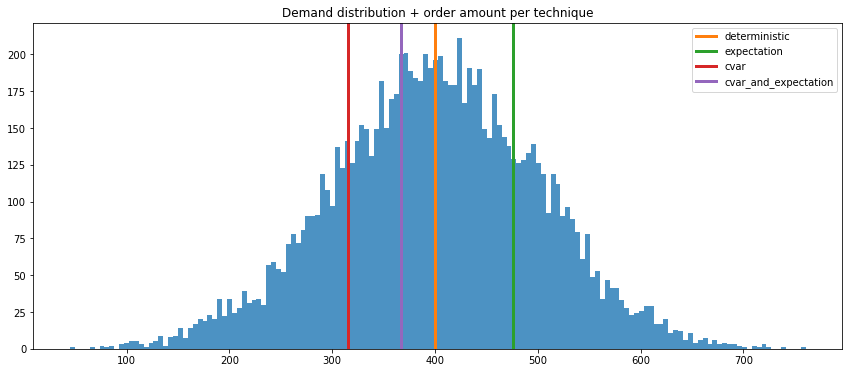

In [13]:
fig, ax = plt.subplots(figsize=(14.5,6))
demands = simulate_outcome(400)[1]
demands = np.array(simulate_outcome(400, nb_samples=10000)[1])
ax.hist(demands, n_bins, alpha=0.8)

for solution_name, order_amount in all_solutions.items():
    ax.axvline(
        x=order_amount,
        label=solution_name,
        color=next(ax._get_lines.prop_cycler)['color'],
        linewidth=3,
    )

plt.title("Demand distribution + order amount per technique")
plt.legend()
plt.show()

The bellow graphs simulate the distribtion of the profit corresponding to the optimal amount of the different techniques. In particular we see how:
- Optimizing for expectation yields the largest profit on average but it has the "fattest" tail as well with a chance of large loss
- cVaR is a conservative solution with a thinner tail and therefore smaller probability of incurring large losses but its profit is also capped at a lower value
- Mixing the expectaion objective with the cVaR results in intermediate solutions

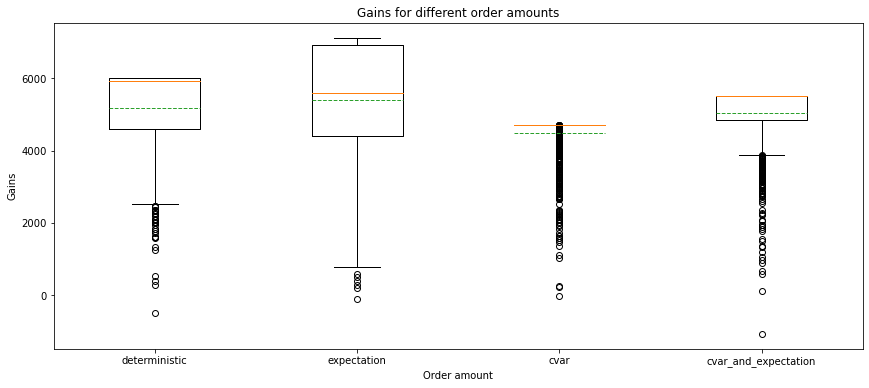

In [14]:
plt.figure(figsize=(14.5,6))
plt.boxplot(
    [simulate_outcome(order)[0] for order in all_solutions.values()], showmeans=True, meanline=True,
)
plt.xticks(np.arange(1, len(all_solutions) + 1), all_solutions.keys())

plt.title("Gains for different order amounts")
plt.xlabel("Order amount")
plt.ylabel("Gains")
plt.show()

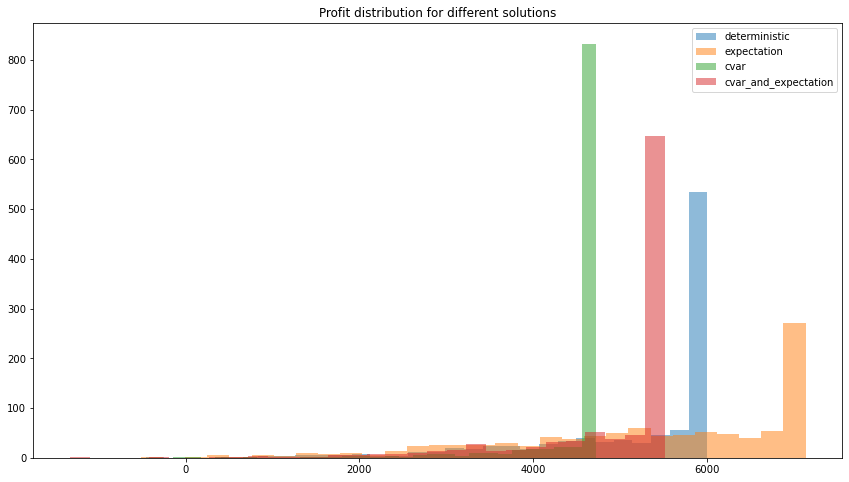

In [15]:
plt.figure(figsize=(14.5,8))
for solution_name, order_amount in all_solutions.items():
    plt.hist(
        simulate_outcome(order_amount)[0],
        30,
        label = solution_name,
        alpha = 0.5
    )
plt.title('Profit distribution for different solutions')
plt.legend()
plt.show()